# CS 1656 – Introduction to Data Science (Spring 2020) 

## Instructor: Alexandros Labrinidis and Evangelos Karageorgos /Teaching Assistant: Xiaoting Li

## Term Project 

**Released: March 23, 2020**

**Due: April 21, 2020**

In [270]:
# Your name: Erik Roeckel
# Your github ID: erik-roeckel
# Your pitt username: EFR11

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `pgh_bike.ipynb` that will:
* [Task 1] access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [271]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import ssl
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from collections import Counter, defaultdict

ssl._create_default_https_context = ssl._create_unverified_context
# Feel free to add here any other libraries as specified in the project description

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [272]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

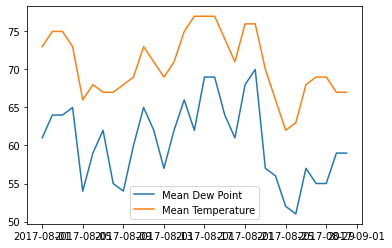

In [273]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.read_csv('http://data.cs1656.org/KPIT_Aug17.csv',\
                       sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [274]:
#read the data from all quarters into a data frame
df_q1 = pd.read_csv('HealthyRideRentals2019-Q1.csv', sep=',', engine='python')
df_q2 = pd.read_csv('HealthyRideRentals2019-Q2.csv', sep=',', engine='python')
df_q3 = pd.read_csv('HealthyRideRentals2019-Q3.csv', sep=',', engine='python')
df_test = pd.read_csv('test.csv', sep=',', engine='python')
df_test['Startime'] = pd.to_datetime(df_test['Starttime'])
df_test['hour'] = df_test['Startime'].dt.hour
df_test['date'] = df_test['Startime'].dt.date
df_test['month'] = df_test['Startime'].dt.month
df_test['day'] = df_test['Startime'].dt.day
#df_all = pd.concat([df_q3, df_q2, df_q1])
df_all = df_q1.append([df_q2, df_q3])

df_all['Startime'] = pd.to_datetime(df_all['Starttime'])
df_all['hour'] = df_all['Startime'].dt.hour
df_all['date'] = df_all['Startime'].dt.date
df_all['month'] = df_all['Startime'].dt.month
df_all['day'] = df_all['Startime'].dt.day


In [275]:
# calculate daily breakdown for each station (fromCNT, toCNT, rebalCNT)
df_from = df_all.groupby(['From station id', 'date', 'month', 'day'])['From station id'].count().rename('fromCNT').reset_index()
df_to = df_all.groupby(['To station id', 'date', 'month', 'day'])['To station id'].count().rename('toCNT').reset_index()
df_sorted = df_all.sort_values(['Bikeid','Startime'], ascending = True)
df_sorted['pre_id'] = df_sorted['To station id'].shift(1)
df_sorted['pre_bike'] = df_sorted['Bikeid'].shift(1)
df_new = df_sorted.loc[(df_sorted['From station id'] != df_sorted['pre_id']) & (df_sorted['Bikeid'] == df_sorted['pre_bike'])]
df_rebal = df_new.groupby(['From station id', 'date', 'month', 'day'])['From station id'].count().rename('rebalCNT').reset_index()
df_from.rename(columns = {'From station id': 'Stationid'}, inplace = True)
df_to.rename(columns = {'To station id': 'Stationid'}, inplace = True)
df_rebal.rename(columns = {'From station id': 'Stationid'}, inplace = True)

print("Daily Breakdown\n")
print(df_from.head(20))
print(df_to.head(20))
print(df_rebal.head(20))

Daily Breakdown

    Stationid        date  month  day  fromCNT
0       666.0  2019-07-20      7   20        1
1       666.0  2019-08-02      8    2        2
2      1000.0  2019-01-01      1    1        4
3      1000.0  2019-01-02      1    2        2
4      1000.0  2019-01-04      1    4        2
5      1000.0  2019-01-05      1    5        5
6      1000.0  2019-01-06      1    6        1
7      1000.0  2019-01-07      1    7        2
8      1000.0  2019-01-08      1    8        2
9      1000.0  2019-01-09      1    9        2
10     1000.0  2019-01-10      1   10        1
11     1000.0  2019-01-11      1   11        1
12     1000.0  2019-01-15      1   15        3
13     1000.0  2019-01-16      1   16        1
14     1000.0  2019-01-18      1   18        2
15     1000.0  2019-01-19      1   19        3
16     1000.0  2019-01-23      1   23        1
17     1000.0  2019-01-27      1   27        3
18     1000.0  2019-02-03      2    3        3
19     1000.0  2019-02-04      2    4      

### Task 1.2

In [276]:
#calculate monthly breakdown for each station (fromCNT, toCNT, rebalCNT)
temp = df_all.copy()
df_from_month = temp.groupby(['From station id', 'month'])['From station id'].count().rename('fromCNT').reset_index()
df_to_month = temp.groupby(['To station id', 'month'])['To station id'].count().rename('toCNT').reset_index()
df_sort_month = df_all.sort_values(['Bikeid','Startime'], ascending = True)
df_sort_month['pre_id'] = df_sort_month['To station id'].shift(1)
df_sort_month['pre_bike'] = df_sort_month['Bikeid'].shift(1)
df_new_month = df_sort_month.loc[(df_sort_month['From station id'] != df_sort_month['pre_id']) & (df_sort_month['Bikeid'] == df_sort_month['pre_bike'])]
df_rebal_month = df_new_month.groupby(['From station id', 'month'])['From station id'].count().rename('rebalCNT').reset_index()
df_from_month.rename(columns = {'From station id': 'Stationid'}, inplace = True)
df_to_month.rename(columns = {'To station id': 'Stationid'}, inplace = True)
df_rebal_month.rename(columns = {'From station id': 'Stationid'}, inplace = True)

print("Monthly Breakdown\n")
print(df_from_month.head(20))
print(df_to_month.head(20))
print(df_rebal_month.head(20))

Monthly Breakdown

    Stationid  month  fromCNT
0       666.0      7        1
1       666.0      8        2
2      1000.0      1       35
3      1000.0      2       51
4      1000.0      3      132
5      1000.0      4      392
6      1000.0      5      601
7      1000.0      6      666
8      1000.0      7      672
9      1000.0      8      586
10     1000.0      9      522
11     1001.0      1       59
12     1001.0      2       61
13     1001.0      3      117
14     1001.0      4      276
15     1001.0      5      429
16     1001.0      6      498
17     1001.0      7      552
18     1001.0      8      470
19     1001.0      9      415
    Stationid  month  toCNT
0      1000.0      1     43
1      1000.0      2     58
2      1000.0      3    174
3      1000.0      4    434
4      1000.0      5    654
5      1000.0      6    719
6      1000.0      7    693
7      1000.0      8    640
8      1000.0      9    564
9      1001.0      1     82
10     1001.0      2     80
11     1001.0  

---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [277]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on


filter_month = 4
filter_stationID = 1046

# get user input for filter variables
temp_month = input("Enter filter month: ")
temp_stationID = input("Enter filter StationID: ")
if(1 <= int(temp_month) <= 9):
    filter_month = int(temp_month)
if(int(temp_stationID) >= 0):
    filter_stationID = int(temp_stationID)



Enter filter month: 4
Enter filter StationID: 1000


### Task 2.1

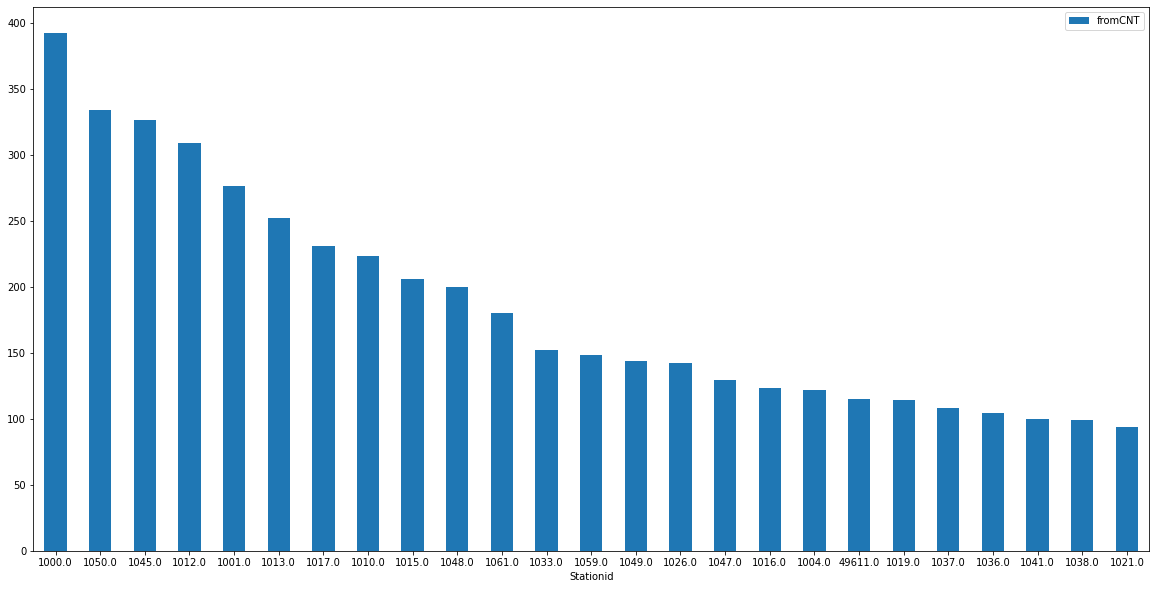

In [278]:
df_temp = df_from_month.loc[df_from_month['month'] == filter_month].copy()
df_popularity = df_temp.sort_values(['fromCNT'], ascending = False).head(25)
pop_graph = df_popularity.plot.bar(x='Stationid', y='fromCNT', figsize=(20,10), rot =0)

### Task 2.2

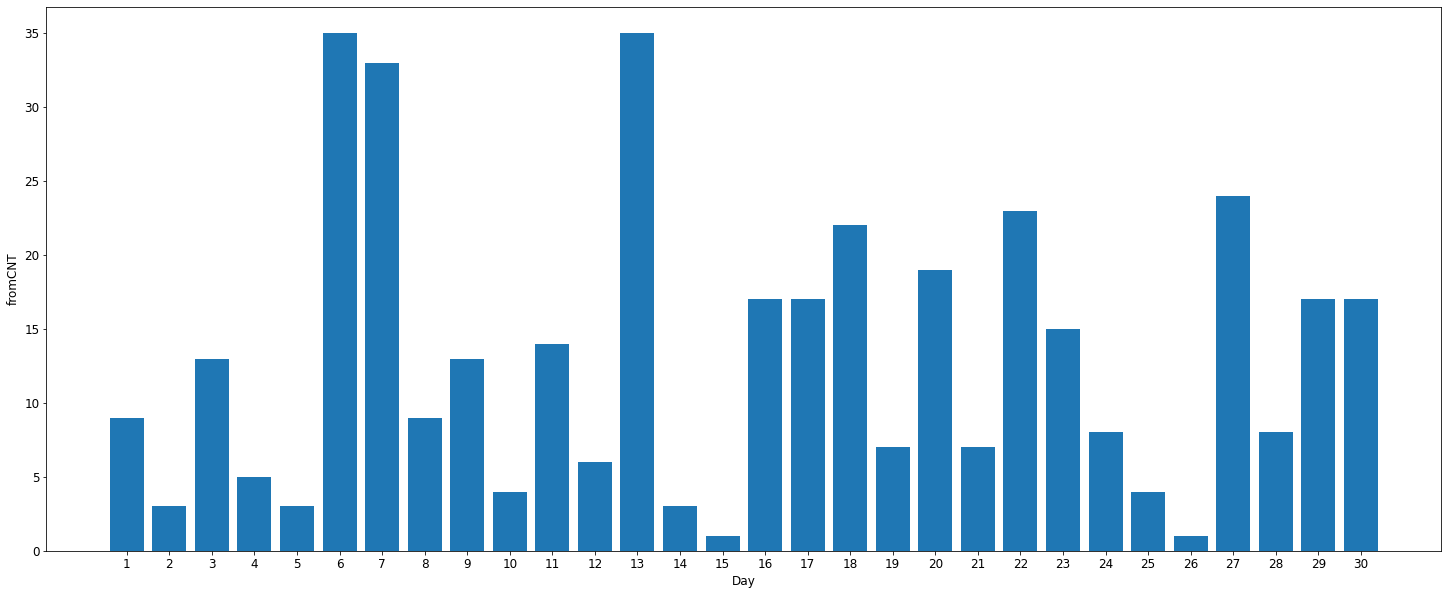

In [279]:
months = {'1': 31, '2': 28, '3': 31, '4': 30, '5': 31, '6': 30, '7': 31, '8': 31, '9': 30, '10': 31}
num_days = months[str(filter_month)]

df_all_days = df_from.loc[(df_from['month'] == filter_month) & (df_from['Stationid'] == filter_stationID)]

fig = plt.figure(figsize=(25,10))
plt.bar(df_all_days['day'], df_all_days['fromCNT'], align='center')
plt.xticks(range(1, num_days + 1), range(1, num_days + 1), rotation = 0, fontsize=12)
plt.yticks(fontsize= 12)
plt.xlabel('Day', fontsize= 12)
plt.ylabel('fromCNT', fontsize= 12)
plt.show()
    

### Task 2.3

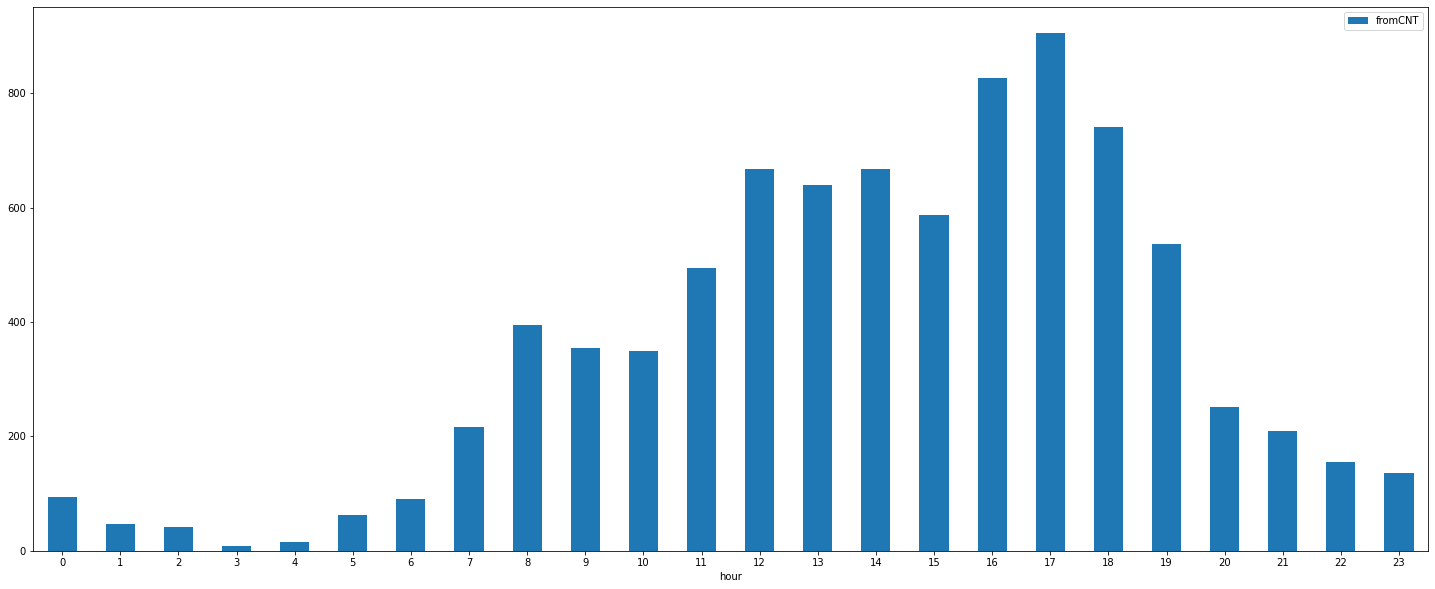

In [280]:
df_from_hours = df_all.groupby(['From station id', 'date', 'month', 'hour'])['From station id'].count().rename('fromCNT').reset_index()
df_monthly_breakdown = df_from_hours.loc[df_from_hours['month'] == filter_month]
df_hourly_breakdown = df_monthly_breakdown.groupby(['hour'])['fromCNT'].sum().rename('fromCNT').reset_index()
hourly_graph = df_hourly_breakdown.plot.bar(x='hour', y='fromCNT', xticks=range(0,24), figsize=(25,10), rot =0)

### Task 2.4

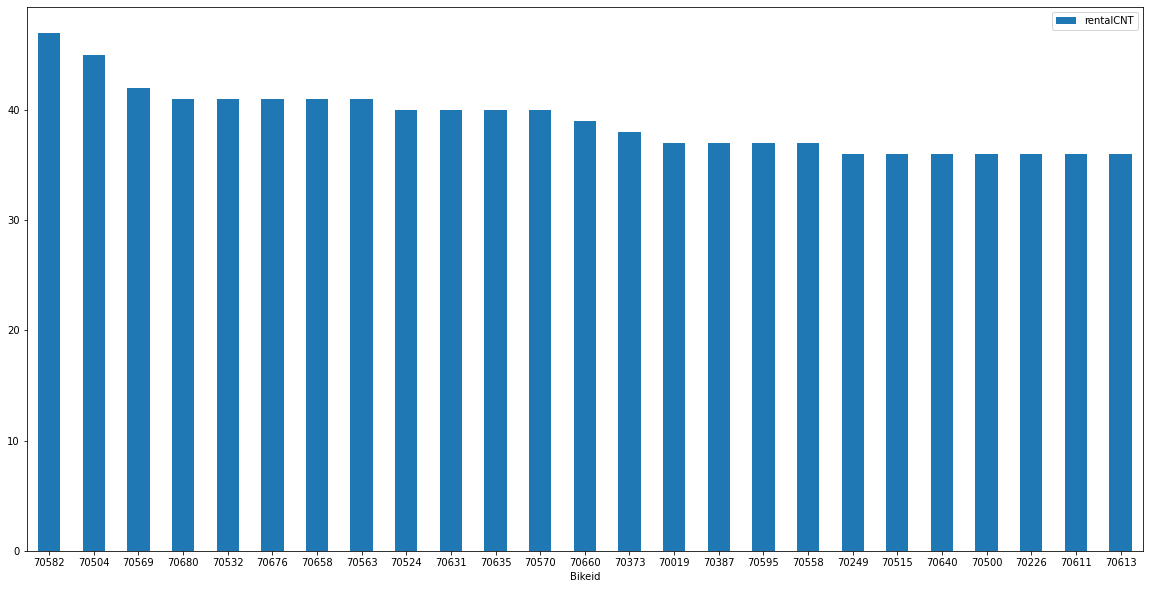

In [281]:
df_bikes = df_all.groupby(['Bikeid', 'month'])['Bikeid'].count().rename('rentalCNT').reset_index()
df_bike_rentals = df_bikes.loc[df_bikes['month'] == filter_month]
popular_bikes = df_bike_rentals.sort_values('rentalCNT', ascending=False).head(25)
rentals_graph = popular_bikes.plot.bar(x='Bikeid', y='rentalCNT', figsize=(20,10), rot=0)

---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1

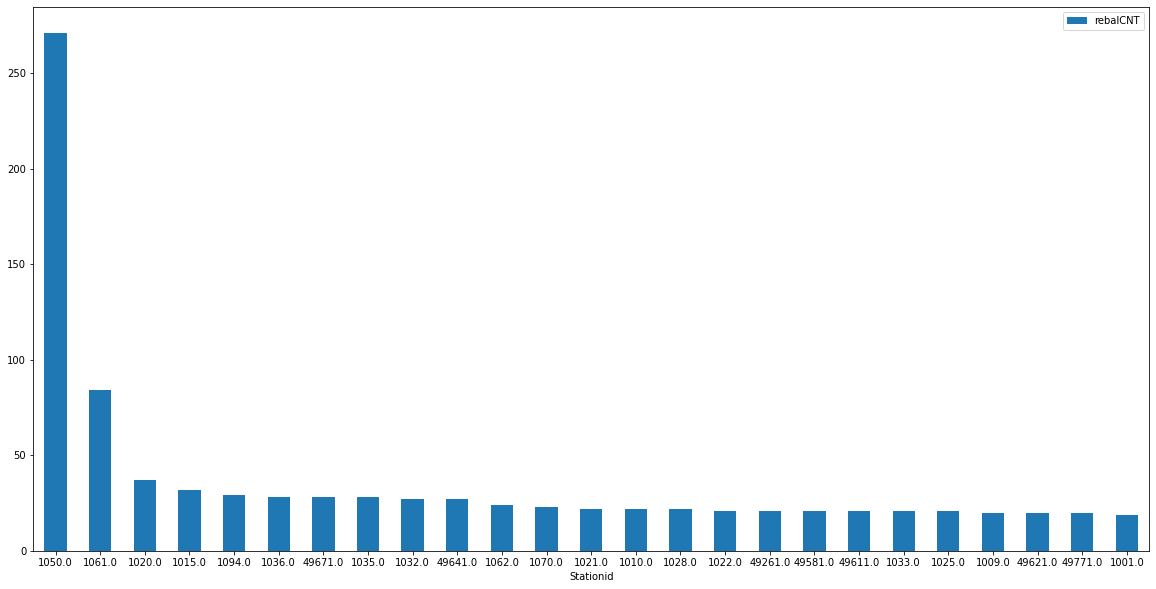

In [282]:
df_rebal_temp = df_rebal_month.loc[df_rebal_month['month'] == filter_month].copy()
df_rebal_popularity = df_rebal_temp.sort_values(['rebalCNT'], ascending = False).head(25)
rebal_pop_graph = df_rebal_popularity.plot.bar(x='Stationid', y='rebalCNT', figsize=(20,10), rot =0)

### Task 3.2

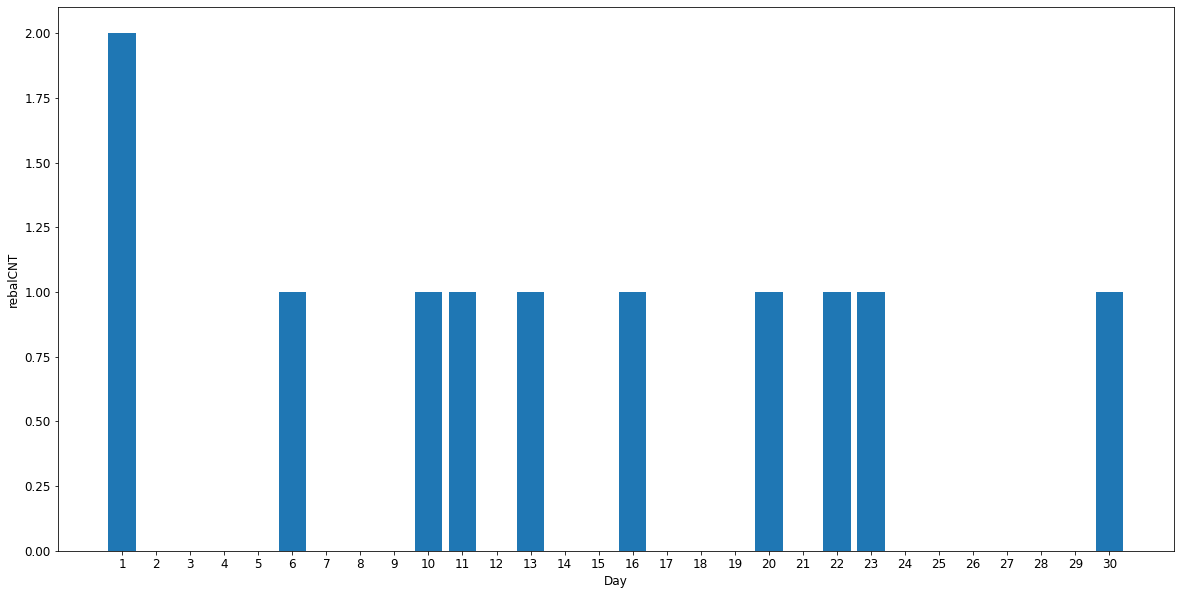

In [283]:
df_rebal_breakdown = df_rebal.loc[(df_rebal['month'] == filter_month) & (df_rebal['Stationid'] == filter_stationID)]
fig = plt.figure(figsize=(20,10))
plt.bar(df_rebal_breakdown['day'], df_rebal_breakdown['rebalCNT'], align='center')
plt.xticks(range(1, num_days + 1), range(1, num_days + 1), rotation = 0, fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel('Day', fontsize=12)
plt.ylabel('rebalCNT', fontsize=12)
plt.show()

---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1

In [284]:
#creates data frame to store rebalance and from data for each station id based on months of third quarter (7, 8, 9)
df_q3['Startime'] = pd.to_datetime(df_q3['Starttime'])
df_q3['date'] = df_q3['Startime'].dt.date
df_q3['month'] = df_q3['Startime'].dt.month
df_cluster_from = df_q3.groupby(['From station id','month'])['From station id'].count().rename('fromCNT').reset_index()
df_cluster_from.rename(columns = {'From station id': 'Stationid'}, inplace = True)
df_cluster_from['fromCNT7'] = df_cluster_from.loc[df_cluster_from['month'] == 7]['fromCNT']
df_cluster_from['fromCNT8'] = df_cluster_from.loc[df_cluster_from['month'] == 8]['fromCNT']
df_cluster_from['fromCNT9'] = df_cluster_from.loc[df_cluster_from['month'] == 9]['fromCNT']
aggregation = {'fromCNT7': 'sum', 'fromCNT8': 'sum', 'fromCNT9': 'sum'}
df_q3_from = df_cluster_from.groupby(df_cluster_from['Stationid']).aggregate(aggregation)

df_sort = df_q3.sort_values(['Bikeid','Startime'], ascending = True)
df_sort['pre_id'] = df_sort['To station id'].shift(1)
df_sort['pre_bike'] = df_sort['Bikeid'].shift(1)
df_temp_month = df_sort.loc[(df_sort['From station id'] != df_sort['pre_id']) & (df_sort['Bikeid'] == df_sort['pre_bike'])]
df_cluster_rebal = df_temp_month.groupby(['From station id', 'month'])['From station id'].count().rename('rebalCNT').reset_index()
df_cluster_rebal.rename(columns = {'From station id': 'Stationid'}, inplace = True)
df_cluster_rebal['rebalCNT7'] = df_cluster_rebal.loc[df_cluster_rebal['month'] == 7]['rebalCNT']
df_cluster_rebal['rebalCNT8'] = df_cluster_rebal.loc[df_cluster_rebal['month'] == 8]['rebalCNT']
df_cluster_rebal['rebalCNT9'] = df_cluster_rebal.loc[df_cluster_rebal['month'] == 9]['rebalCNT']
agg = {'rebalCNT7': 'sum', 'rebalCNT8': 'sum', 'rebalCNT9': 'sum'}
df_q3_rebal = df_cluster_rebal.groupby(df_cluster_rebal['Stationid']).aggregate(agg)

df_q3_data = pd.merge(df_q3_from, df_q3_rebal, on=['Stationid'], how='outer')
print(df_q3_data.head(20))

           fromCNT7  fromCNT8  fromCNT9  rebalCNT7  rebalCNT8  rebalCNT9
Stationid                                                               
666.0           1.0       2.0       0.0        1.0        2.0        0.0
1000.0        672.0     586.0     522.0       19.0       19.0       21.0
1001.0        552.0     470.0     415.0       63.0       10.0       20.0
1002.0        181.0     188.0     167.0       11.0       32.0       24.0
1003.0        128.0     146.0     110.0       10.0       12.0       16.0
1004.0        163.0     174.0     144.0        5.0        6.0        7.0
1005.0        123.0      93.0      84.0       30.0       26.0       10.0
1006.0        104.0      98.0      71.0        5.0       15.0       24.0
1007.0         37.0      33.0      54.0       10.0        3.0       14.0
1008.0         73.0      70.0      49.0       31.0       41.0       27.0
1009.0        179.0     167.0     176.0       11.0       15.0       16.0
1010.0        284.0     258.0     291.0       26.0 

In [285]:
df_q3_data = df_q3_data.fillna(0)

#Run k-means for 3 different values of k
kmeans_one = KMeans(n_clusters=5, init = 'k-means++', random_state=5000)
kmeans_one.fit(df_q3_data[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])
one = Counter(kmeans_one.labels_)

kmeans_two = KMeans(n_clusters=15, init = 'k-means++', random_state=5000)
kmeans_two.fit(df_q3_data[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])
two = Counter(kmeans_two.labels_)

kmeans_three = KMeans(n_clusters=25, init = 'k-means++', random_state=5000)
kmeans_three.fit(df_q3_data[['fromCNT7', 'fromCNT8', 'fromCNT9', 'rebalCNT7', 'rebalCNT8', 'rebalCNT9']])
three = Counter(kmeans_three.labels_)

In [286]:
# preprocesses data for DBSCAN using all attributes of q3 data
# note the actual DBSCAN algortihm is run in 4.2
X = df_q3_data.copy()
X_scaled = StandardScaler().fit_transform(X)
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
#runs DBSCAN with low eps, low min_samples
db_one = DBSCAN(eps = 0.1, min_samples = 3).fit(X_principal)

#runs DBSCAN with low eps value, high min_samples
db_two = DBSCAN(eps = 0.1, min_samples = 10).fit(X_principal)

#runs DBSCAN with somewhat high eps, high min_samples
db_three = DBSCAN(eps = 0.5, min_samples = 10).fit(X_principal)

#runs DBSCAN with somewhat high eps, low min_samples
db_four = DBSCAN(eps = 0.5, min_samples =3).fit(X_principal)


### Task 4.2

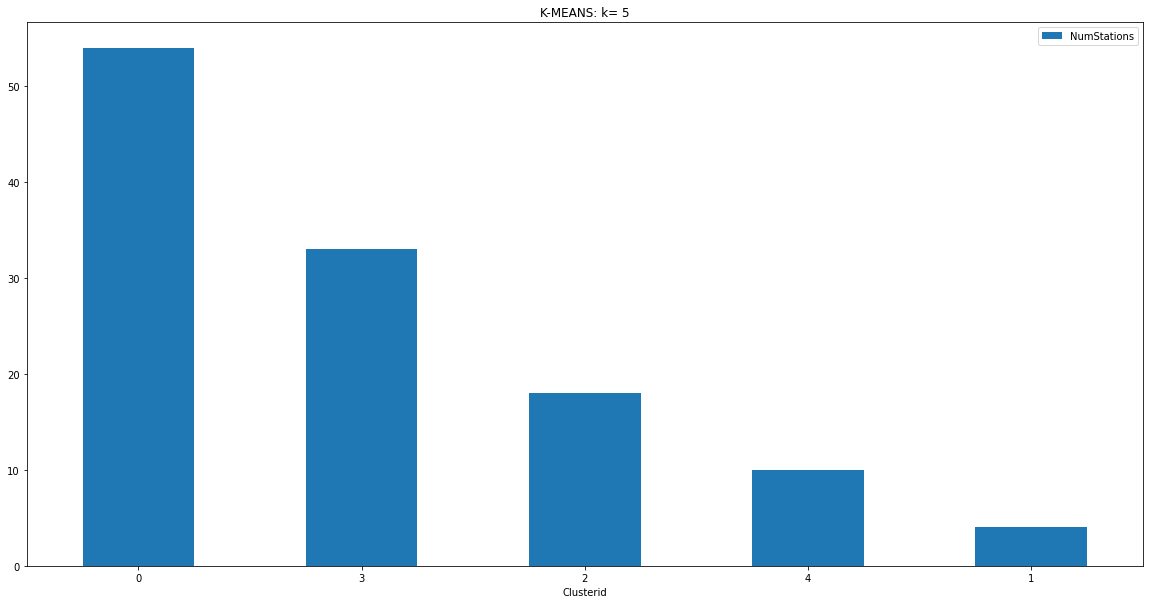

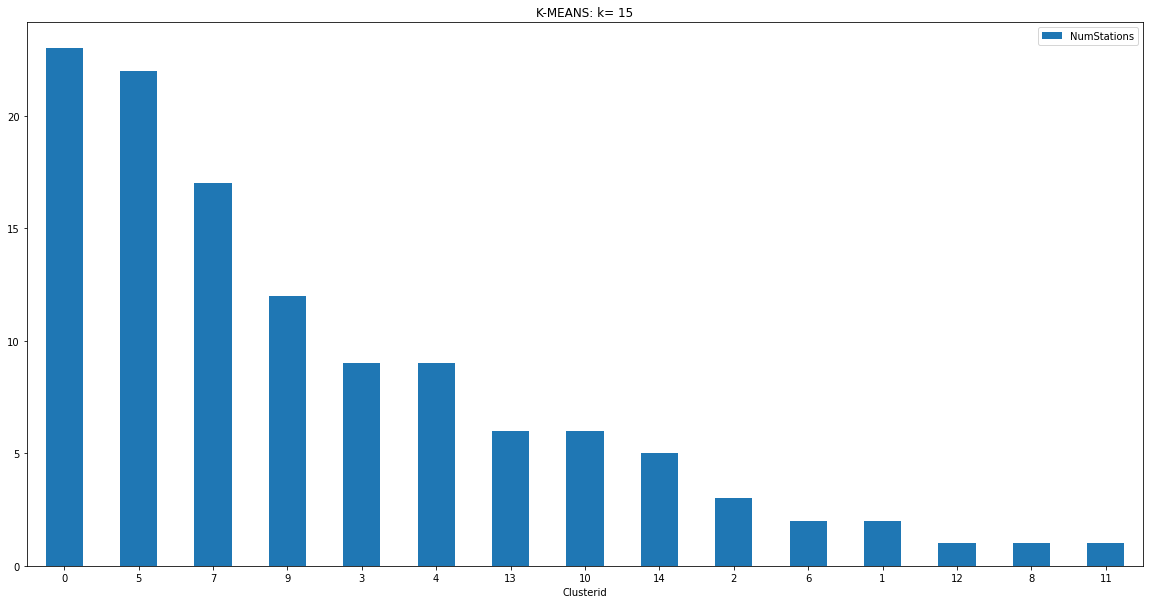

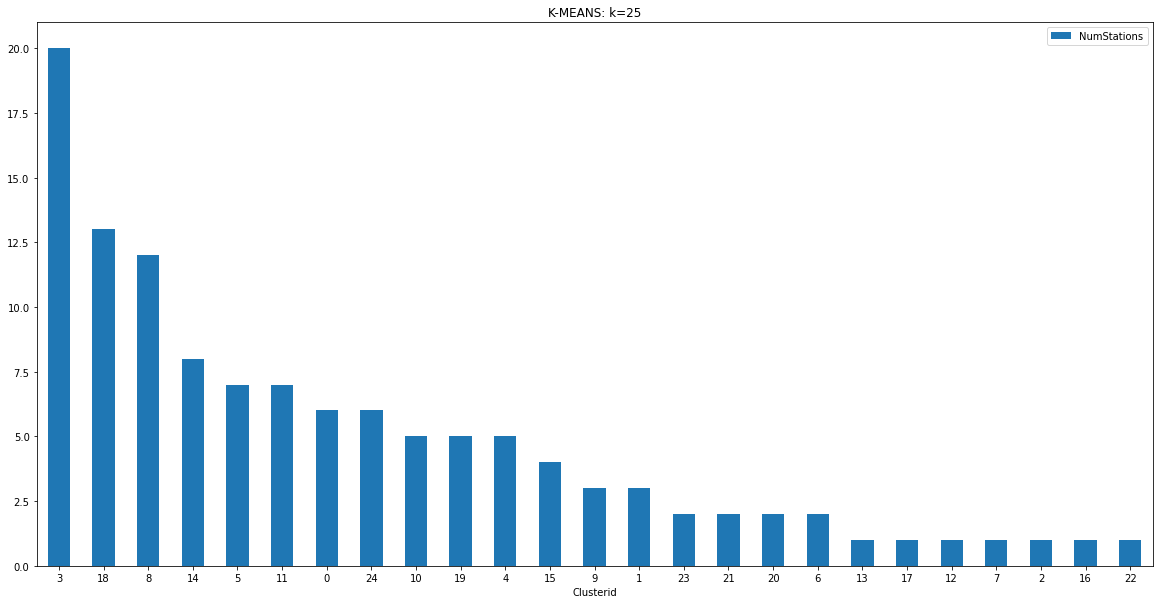

In [287]:
#display graphs for k-means cluster distribution where k= 5,15,25
# displays graph of k-means cluster distributions where k=5
df_one = pd.DataFrame.from_dict(one, orient='index', columns=['NumStations'])
df_one['Clusterid'] = one.keys()
df_one_sort = df_one.sort_values(by=['NumStations'], ascending=False)
k_graph_one = df_one_sort.plot.bar(x='Clusterid', y='NumStations', title='K-MEANS: k= 5', figsize=(20,10), rot =0)

# displays graph of k-means cluster distributions where k=15
df_two = pd.DataFrame.from_dict(two, orient='index', columns=['NumStations'])
df_two['Clusterid'] = two.keys()
df_two_sort = df_two.sort_values(by=['NumStations'], ascending=False)
k_graph_two = df_two_sort.plot.bar(x='Clusterid', y='NumStations', title='K-MEANS: k= 15', figsize=(20,10), rot =0)

# displays graph of k-means cluster distributions where k=25
df_three = pd.DataFrame.from_dict(three, orient='index', columns=['NumStations'])
df_three['Clusterid'] = three.keys()
df_three_sort = df_three.sort_values(by=['NumStations'], ascending=False)
k_graph_three = df_three_sort.plot.bar(x='Clusterid', y='NumStations', title='K-MEANS: k=25', figsize=(20,10), rot = 0)

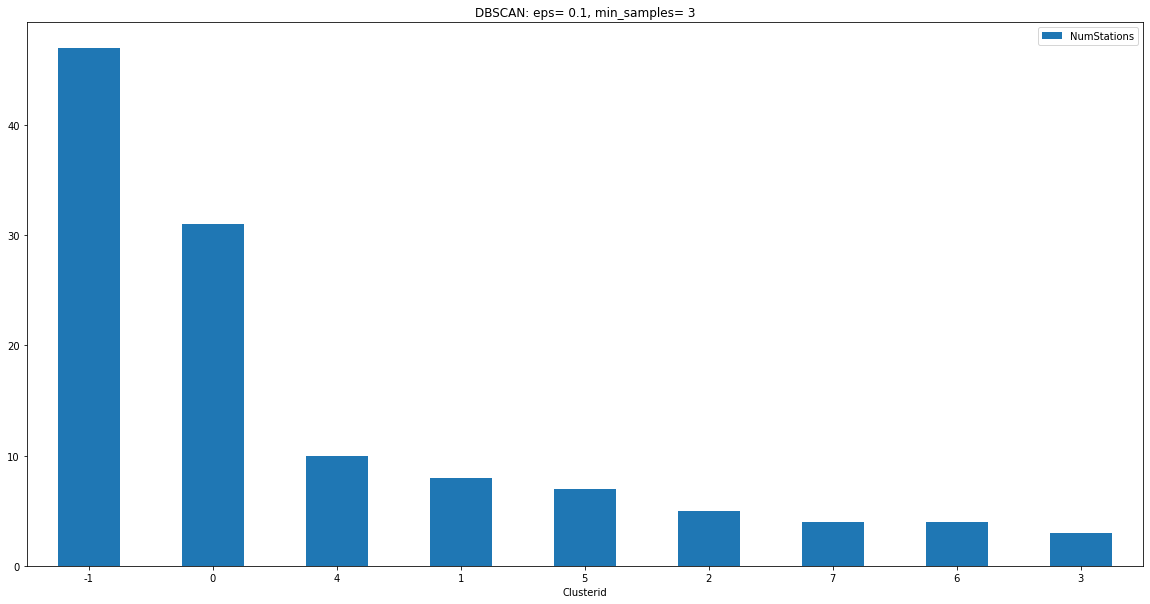

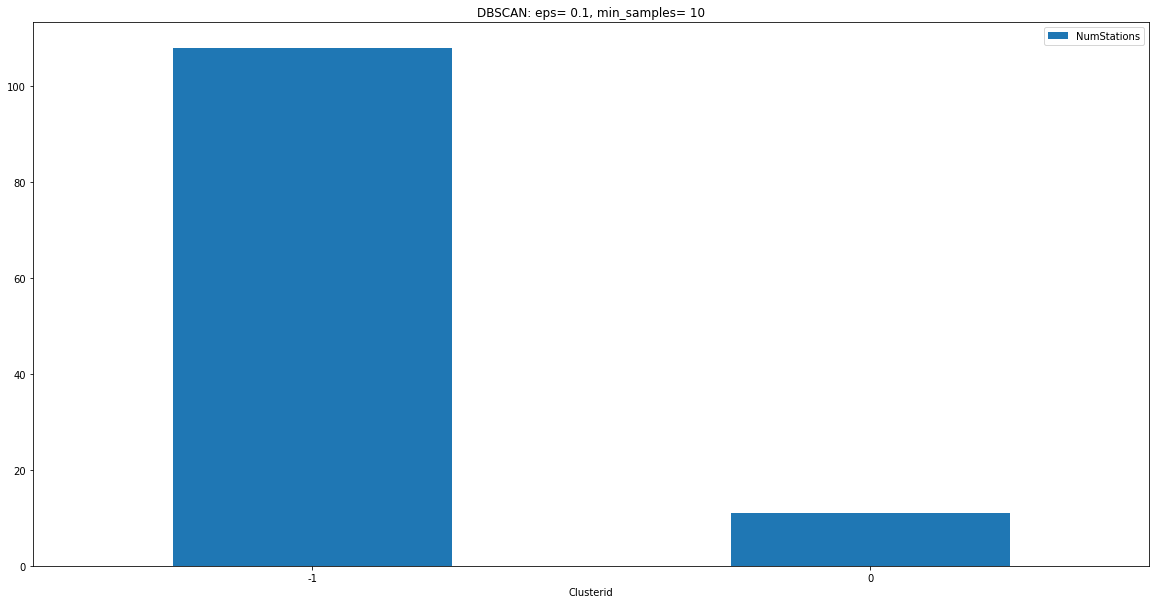

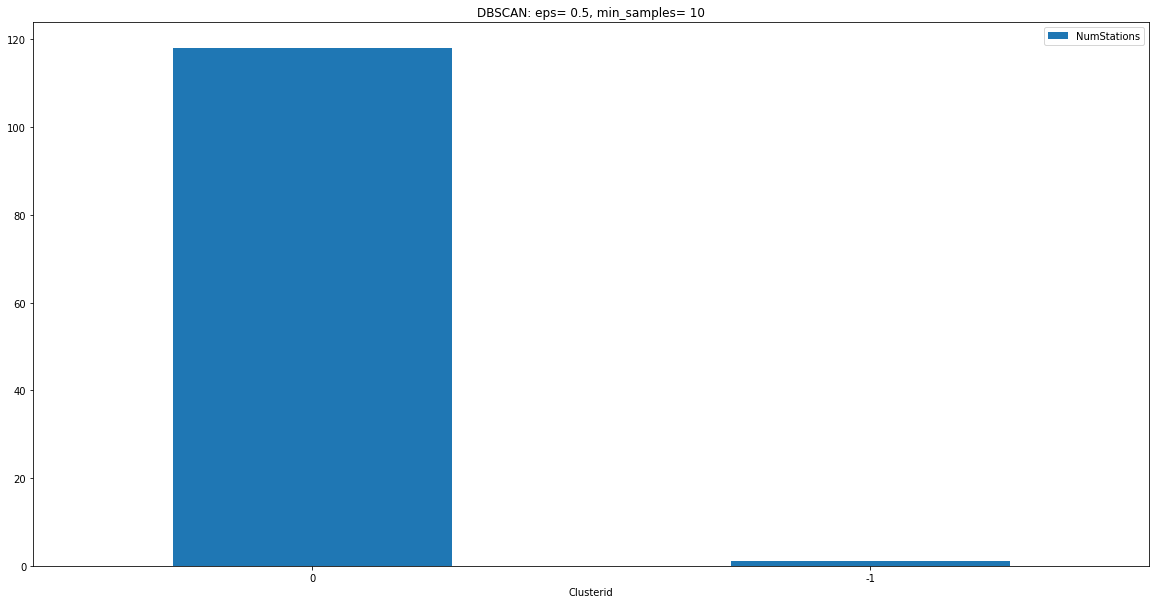

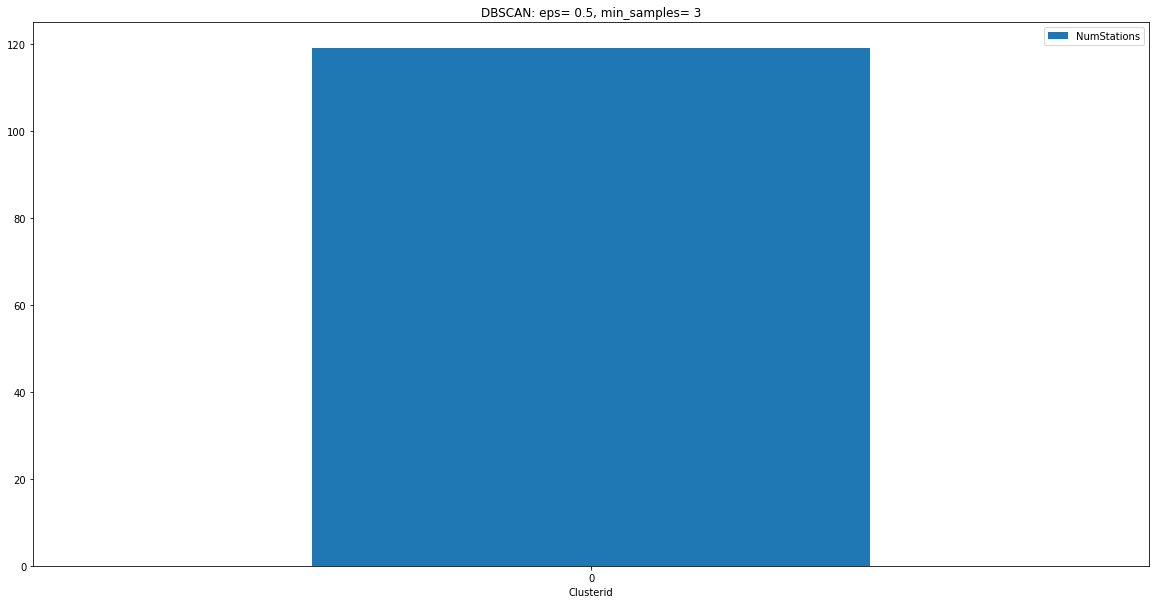

In [288]:
#display graphs for all DBSCAN cluster distributions using combinations of low/high eps, low/high min_samples
#runs DBSCAN with low eps, low min_samples
labels_one = db_one.labels_
cluster_count_one = Counter(labels_one)
df_dbscan_one = pd.DataFrame.from_dict(cluster_count_one, orient='index', columns=['NumStations'])
df_dbscan_one['Clusterid'] = cluster_count_one.keys()
df_dbscan_one_sort = df_dbscan_one.sort_values(by=['NumStations'], ascending=False)
db_graph_one = df_dbscan_one_sort.plot.bar(x='Clusterid', y='NumStations', title = "DBSCAN: eps= 0.1, min_samples= 3", figsize=(20,10), rot =0)

#runs DBSCAN with low eps value, high min_samples
labels_two = db_two.labels_
cluster_count_two = Counter(labels_two)
df_dbscan_two = pd.DataFrame.from_dict(cluster_count_two, orient='index', columns=['NumStations'])
df_dbscan_two['Clusterid'] = cluster_count_two.keys()
df_dbscan_two_sort = df_dbscan_two.sort_values(by=['NumStations'], ascending=False)
db_graph_two = df_dbscan_two_sort.plot.bar(x='Clusterid', y='NumStations', title = "DBSCAN: eps= 0.1, min_samples= 10", figsize=(20,10), rot =0)

#runs DBSCAN with somewhat high eps, high min_samples
labels_three = db_three.labels_
cluster_count_three = Counter(labels_three)
df_dbscan_three = pd.DataFrame.from_dict(cluster_count_three, orient='index', columns=['NumStations'])
df_dbscan_three['Clusterid'] = cluster_count_three.keys()
df_dbscan_three_sort = df_dbscan_three.sort_values(by=['NumStations'], ascending=False)
db_graph_three = df_dbscan_three_sort.plot.bar(x='Clusterid', y='NumStations', title = "DBSCAN: eps= 0.5, min_samples= 10",figsize=(20,10), rot =0)

#runs DBSCAN with somewhat high eps, low min_samples
labels_four = db_four.labels_
cluster_count_four = Counter(labels_four)
df_dbscan_four = pd.DataFrame.from_dict(cluster_count_four, orient='index', columns=['NumStations'])
df_dbscan_four['Clusterid'] = cluster_count_four.keys()
df_dbscan_four_sort = df_dbscan_four.sort_values(by=['NumStations'], ascending=False)
db_graph_four = df_dbscan_four_sort.plot.bar(x='Clusterid', y='NumStations', title = "DBSCAN: eps= 0.5, min_samples= 3",figsize=(20,10), rot =0)



### Task 4.3

(Choice of K) I decided on my choices of k (k=5,15,25) by sampling multiple values of k and examining the distibutions of the data. I first did this by extracting my jupyter notebook python code to a seperate file and plotting the k-means distribution on a scatter-plot so I could better visualize the clusters that were formed. After examining these scatter plots with values ranging from k=5-20 I noticed that a larger k provides a better representation of the data. My first value of 5 I picked to show that a small value for k doesn't suffice for the data. I chose 15 for the second value of k because it shows how as k is growing the distributions spreads out more evenly across clusters. My final choice of k=25 was chosen because it represents a relatively large number of clusters and utilmatley shows how the data points start to favor cluster 3. (a) The best value of K was 25, because it best represented the data without clustering the data together too much. This is seen as K is changed from 5 to 15 to 25 that the distibution of the data starts to change and spread out among clusters, while also indicating that cluster 3 is the most favored cluster center. (b) Overall I think that the K-Means algorithm better suited this data set because it displayed a more even distribution of data and didn't cluster the data together too much like DBSCAN did. This is an advantage to K-means because the dataset is fairly large and there is much variability in the calculated data. Being that there is high variability in the data K-Means better represents the data because it maintains the relative position of each data point (making it more representative of the actual input data). Also, the only helpful data gathered from DBSCAN was when I used a value for eps and min_samples.